# TalkingData AdTracking Fraud Detection Challenge

## Introduction

Fraud risk is everywhere, but for companies that advertise online, click fraud can happen at an overwhelming volume, resulting in misleading click data and wasted money. Ad channels can drive up costs by simply clicking on the ad at a large scale. With over 1 billion smart mobile devices in active use every month, China is the largest mobile market in the world and therefore suffers from huge volumes of fradulent traffic.

TalkingData, China’s largest independent big data service platform, covers over 70% of active mobile devices nationwide. They handle 3 billion clicks per day, of which 90% are potentially fraudulent. Their current approach to prevent click fraud for app developers is to measure the journey of a user’s click across their portfolio, and flag IP addresses who produce lots of clicks, but never end up installing apps. With this information, they've built an IP blacklist and device blacklist.

While successful, they want to always be one step ahead of fraudsters and have turned to the Kaggle community for help in further developing their solution. In their 2nd competition with Kaggle, you’re challenged to build an algorithm that predicts whether a user will download an app after clicking a mobile app ad. To support your modeling, they have provided a generous dataset covering approximately 200 million clicks over 4 days!


## Data Processing
For this competition, TalkingData supplied the following:
- train.csv 
- train_sample.csv (100,000 randomly-selected rows of training data, to inspect data before downloading full set)
- test.csv

### Reading the Data
It's worth noting that the training set is 7.54 GB after unzipping; my MacBook Pro 2016 with 8 GB memory will likely have trouble reading the entire dataset. I'll randomly select 1 million rows from the training set instead.

In [427]:
import numpy as np
import pandas as pd
import random
dtypes = {
        'ip'            : 'uint32',
        'app'           : 'uint16',
        'device'        : 'uint16',
        'os'            : 'uint16',
        'channel'       : 'uint16',
        'is_attributed' : 'uint8',
        }



lines = 184903891 # total number of rows in the complete dataset
skiplines = np.random.choice(np.arange(1, lines), size=lines-1-20000000, replace=False)

#sort the list
skiplines=np.sort(skiplines)

In [428]:
df = pd.read_csv('train.csv', skiprows=skiplines, dtype=dtypes)
df.head()
print("%s rows are selected from the original training set" %(len(train)))

10431981 rows are selected from the original training set


In [429]:
df.is_attributed.value_counts()

0    19950494
1       49506
Name: is_attributed, dtype: int64

As seen from the distribution above, the number of clicks that were attributed are unproportionally low. Let's proceed with processing the dataset by chunks and collect all the clicks that were attributed to balance the dataset. 

In [430]:
train_attributed = pd.DataFrame()
chunksize = 10 ** 6

#in each chunk, filter for values that have 'is_attributed'==1, and merge these values into one dataframe
for chunk in pd.read_csv('train.csv', chunksize=chunksize, dtype=dtypes):
    filtered = (chunk[(np.where(chunk['is_attributed']==1, True, False))])
    train_attributed = pd.concat([train_attributed, filtered], ignore_index=True)
    

In [431]:
print("There are %s clicks that were attributed in total." %(len(train_attributed)))
print("This represents %s %% of the complete dataset." %(100*len(train_attributed)/184903891))

There are 456846 clicks that were attributed in total.
This represents 0.24707213976367864 % of the complete dataset.


Let's combine all the attributed clicks with the initial training set (while removing duplicates of course!)

In [432]:
df = pd.concat([df[df.is_attributed ==0], train_attributed], ignore_index=True)

In [433]:
df.is_attributed.value_counts()

0    19950494
1      456846
Name: is_attributed, dtype: int64

### Extract Information from Click Time
Let's create 3 additional columns (i.e. "period", "month" and "hour") based on the "click_time" column. 

In [434]:
train = df
df.head()

,ip,app,device,os,channel,click_time,attributed_time,is_attributed
0,83230,3,1,13,379,2017-11-06 14:32:21,NaN,0
1,17357,3,1,19,379,2017-11-06 14:33:34,NaN,0
2,7755,3,1,13,379,2017-11-06 14:43:25,NaN,0
3,28739,3,1,13,379,2017-11-06 14:50:29,NaN,0
4,30986,3,1,19,379,2017-11-06 14:52:13,NaN,0


In [435]:
train['click_time'] = pd.to_datetime(train['click_time'])
train['period']=pd.cut(train.click_time.dt.hour,[-1,6,12,18,24],labels=['Night','Morning','Afternoon','Evening'])
train['month']=train.click_time.dt.month
train['hour']=train.click_time.dt.hour
train.head()

,ip,app,device,os,channel,click_time,attributed_time,is_attributed,period,month,hour
0,83230,3,1,13,379,2017-11-06 14:32:21,NaN,0,Afternoon,11,14
1,17357,3,1,19,379,2017-11-06 14:33:34,NaN,0,Afternoon,11,14
2,7755,3,1,13,379,2017-11-06 14:43:25,NaN,0,Afternoon,11,14
3,28739,3,1,13,379,2017-11-06 14:50:29,NaN,0,Afternoon,11,14
4,30986,3,1,19,379,2017-11-06 14:52:13,NaN,0,Afternoon,11,14


## Exploratory Analysis

In [383]:
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

### Click Time

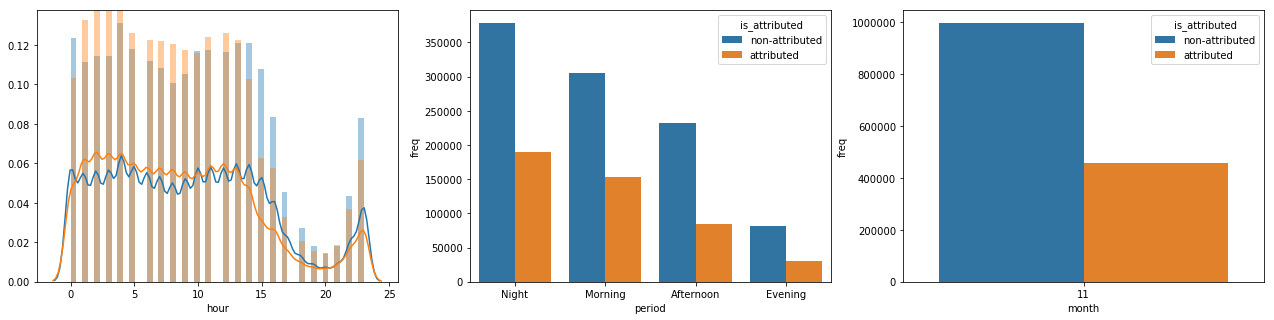

In [11]:
figbi, axe = plt.subplots(1,3, figsize=(22, 5))

sns.distplot(train.loc[train.is_attributed ==0, 'hour'], label = 'attributed', ax=axe[0])
sns.distplot(train.loc[train.is_attributed ==1, 'hour'], label = 'non-attributed', ax=axe[0])
plt.close(2)

period_df = pd.concat([train.loc[train.is_attributed ==0, 'period'].value_counts(),train.loc[train.is_attributed ==1, 'period'].value_counts()], axis=1, join='inner')
period_df.reset_index(inplace=True)
period_df.columns = ['period','non-attributed', 'attributed']
period_df = pd.melt(period_df, id_vars="period", var_name="is_attributed", value_name="freq")
sns.factorplot(x='period', y='freq', hue='is_attributed', data=period_df, kind='bar', ax=axe[1])
plt.close(2)

month_df = pd.concat([train.loc[train.is_attributed ==0, 'month'].value_counts(),train.loc[train.is_attributed ==1, 'month'].value_counts()], axis=1, join='inner')
month_df.reset_index(inplace=True)
month_df.columns = ['month','non-attributed', 'attributed']
month_df = pd.melt(month_df, id_vars="month", var_name="is_attributed", value_name="freq")
sns.factorplot(x='month', y='freq', hue='is_attributed', data=month_df, kind='bar', ax=axe[2])
plt.close(2)


**Observations:**

- Both attributed and non-attributed have a somewhat similar U-shaped distribution of click time (hour), with frequencies that steadily fall between 14:00 - 20:00 and then steadily rise from 21:00 onwards. 

- By grouping the click time by period, it becomes more apparent that most clicks happened during nighttime (i.e. 24:00 - 6:00) and steadily drops during the day. 

- It turns out that all the clicks in this dataset were all collected during the month of November; this feature will not be useful to train the model and should be removed. 
 
*When looking at the above charts, it is very important to keep in mind that attributed clicks only occupy **0.25%** of the dataset.* 

Since I already extracted the hour from the click time, I will remove the month, period, click_time columns as well as the attributed_time column.

In [436]:
train.drop('month', axis=1,inplace=True)
#train.drop('period', axis=1, inplace=True)
train.drop('click_time', axis=1,inplace=True)
train.drop('attributed_time', axis=1,inplace=True)

### Categorical Features: IP, App, Device, OS and Channel

We shall begin by taking a quick look at the number of distinct values in each of those categorical features:

In [14]:
train.nunique()[0:5]

ip         256956
app           356
device       1901
os            212
channel       180
dtype: int64

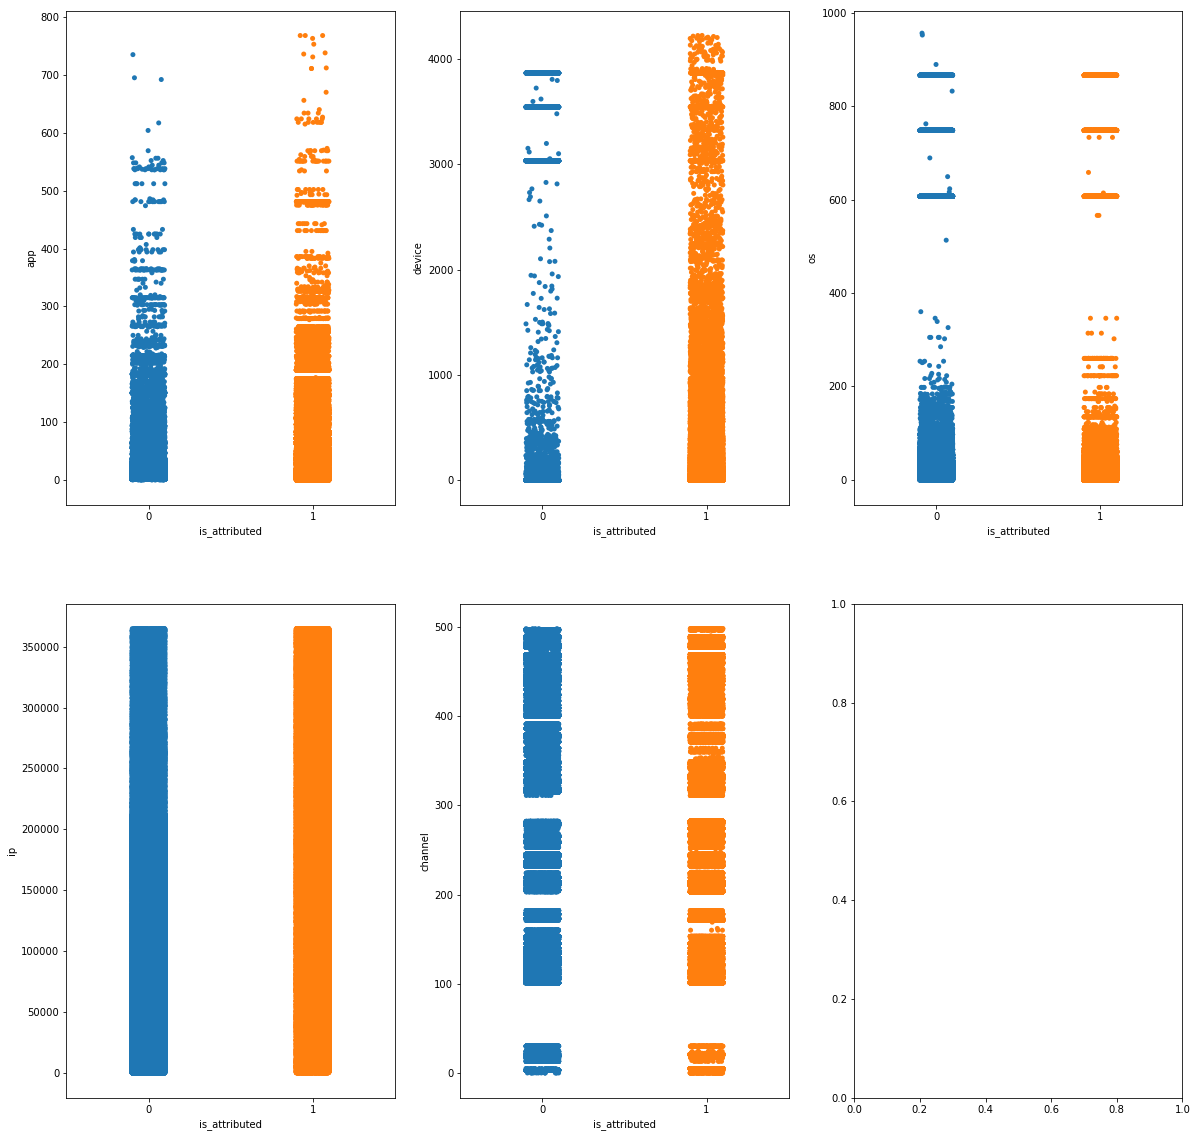

In [15]:
figbi, axe = plt.subplots(2,3, figsize=(20, 20))

x_axis = train["is_attributed"].astype(str)

sns.stripplot(x=x_axis, y=train["app"], jitter=True, ax=axe[0,0])

sns.stripplot(x=x_axis, y=train["device"], jitter=True, ax=axe[0,1])

sns.stripplot(x=x_axis, y=train["os"], jitter=True, ax=axe[0,2])

sns.stripplot(x=x_axis, y=train["ip"], jitter=True, ax=axe[1,0])

sns.stripplot(x=x_axis, y=train["channel"], jitter=True, ax=axe[1,1])

**Observations:**

- As seen from the above univariate analysis, ip address and channel **on their own** may not be good features for useful insights as the distibution between attributed and non-attributed clicks are extremely similar. However, they may be correlated with other features. 

- The device distribution is very different between attributed and non-attributed clicks.

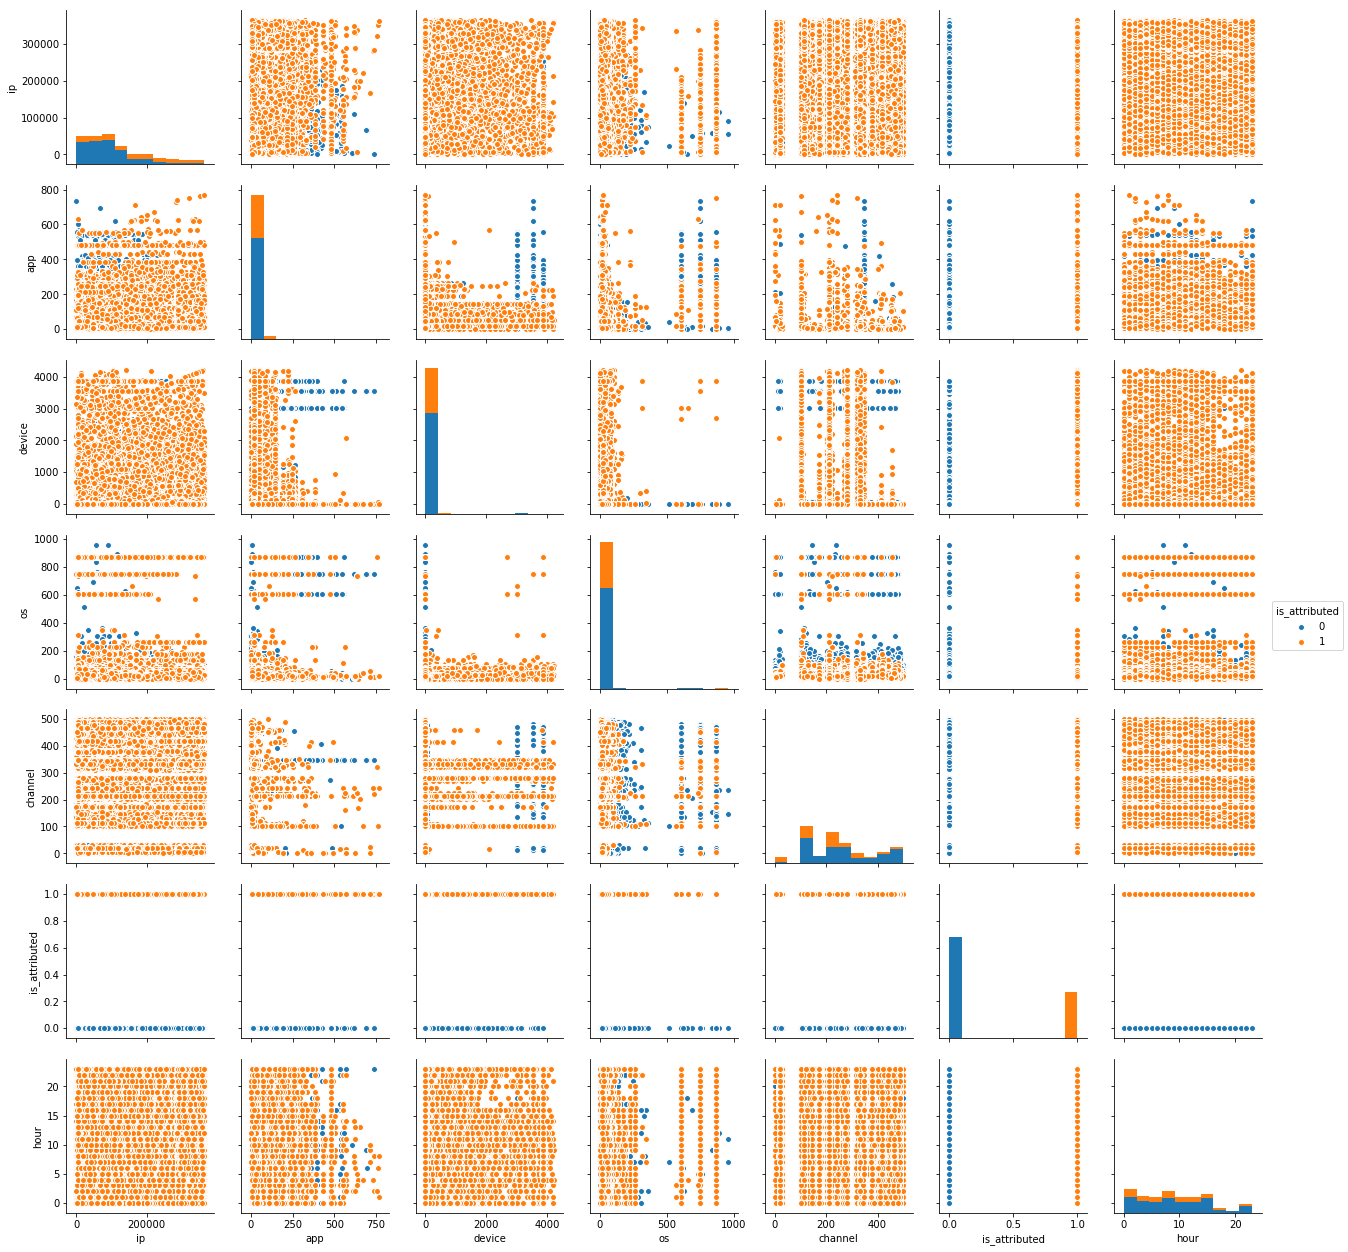

In [20]:
plt.figure()
sns.pairplot(data=train[["ip","app","device","os","channel","is_attributed","hour"]], hue="is_attributed", dropna=True)
plt.show()
plt.savefig("seaborn_pair_plot.png")

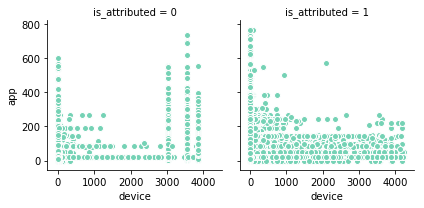

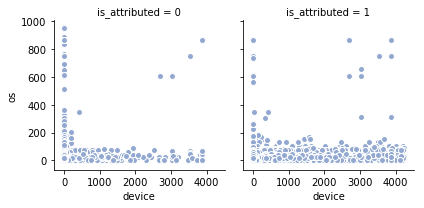

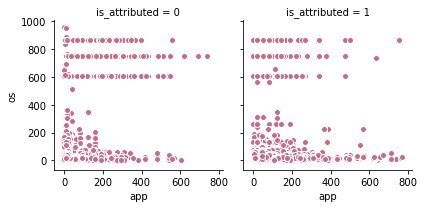

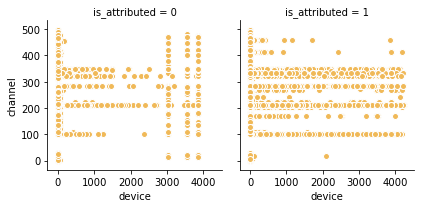

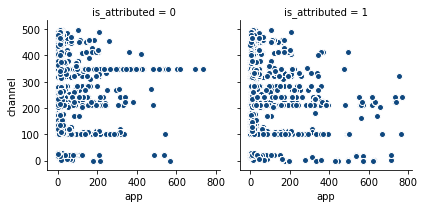

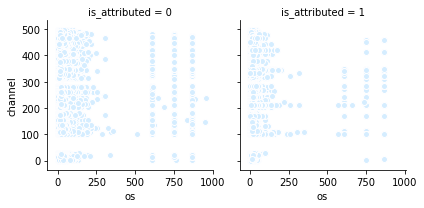

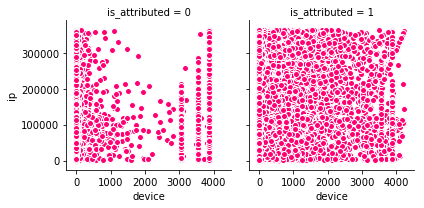

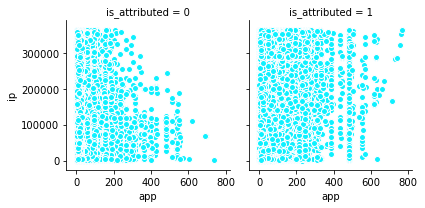

In [16]:
g = sns.FacetGrid(train, col="is_attributed")
g.map(plt.scatter, "device", "app", color="#75D2B5", edgecolor="white")

h = sns.FacetGrid(train, col="is_attributed")
h.map(plt.scatter, "device", "os", color="#92A8D1", edgecolor="white")

i = sns.FacetGrid(train, col="is_attributed")
i.map(plt.scatter, "app", "os", color="#C76C87", edgecolor="white")

j = sns.FacetGrid(train, col="is_attributed")
j.map(plt.scatter, "device", "channel", color="#F0B958", edgecolor="white")

k = sns.FacetGrid(train, col="is_attributed")
k.map(plt.scatter, "app", "channel", color="#0F487F", edgecolor="white")

l = sns.FacetGrid(train, col="is_attributed")
l.map(plt.scatter, "os", "channel", color="#D5EDFF", edgecolor="white")

m = sns.FacetGrid(train, col="is_attributed")
m.map(plt.scatter, "device", "ip", color="#FE0073", edgecolor="white")

n = sns.FacetGrid(train, col="is_attributed")
n.map(plt.scatter, "app", "ip", color="#0FF0FF", edgecolor="white")



**Observations**

- Apps with labels between 100-200 have a higher tendency of being attributed across all devices. 

- Channels of labels 100 and between 300-400 also have a relatively higher distribution of attributed clicks for most devices. 

- The device & IP distribution is just reconfirming the devices distribution I observed earlier. There might really be no need for using IP as a feature.


## Feature Engineering

### Creating Features with Attributed Counts
Creating features for attributed counts of the associated ip, app, device, os and channel

In [437]:
features = ['app','os','channel','device']

for n in range(0,len(features)):
    total_count = train.groupby(features[n])['is_attributed'].count().reset_index()
    total_count.columns = [features[n], features[n]+'_ttl_count']
    attr_count = train[train['is_attributed'] == 1].groupby(features[n])['is_attributed'].count().reset_index()
    attr_count.columns = [features[n], features[n]+'_attr_count']
    count = pd.merge(total_count, attr_count, how='left', on=[features[n]])
    count.columns = [features[n],'ttl','attr']
    count[features[n]+'_attr_rate'] = count['attr']/count['ttl']
    count.drop(['ttl','attr'], axis=1,inplace=True)
    
    train = pd.merge(train, count, how='left', on=[features[n]])
    train[features[n]+'_attr_rate'].fillna(0, inplace=True)

In [438]:
train.head()

,ip,app,device,os,channel,is_attributed,period,hour,app_attr_rate,os_attr_rate,channel_attr_rate,device_attr_rate
0,83230,3,1,13,379,0,Afternoon,14,0.00279,0.014146,0.003082,0.01602
1,17357,3,1,19,379,0,Afternoon,14,0.00279,0.016425,0.003082,0.01602
2,7755,3,1,13,379,0,Afternoon,14,0.00279,0.014146,0.003082,0.01602
3,28739,3,1,13,379,0,Afternoon,14,0.00279,0.014146,0.003082,0.01602
4,30986,3,1,19,379,0,Afternoon,14,0.00279,0.016425,0.003082,0.01602


In [439]:
pair_features = ['os','channel','device']

for n in range(0,3):
    total_count = train.groupby(['app', pair_features[n]])['is_attributed'].count().reset_index()
    total_count.columns = ['app', pair_features[n], 'app_'+pair_features[n]+'_ttl_count']
    attr_count = train[train['is_attributed'] == 1].groupby(['app', pair_features[n]])['is_attributed'].count().reset_index()
    attr_count.columns = ['app', pair_features[n], 'app_'+pair_features[n]+'_attr_count']
    count = pd.merge(total_count, attr_count, how='left', on=['app', pair_features[n]])
    count.columns = ['app', pair_features[n],'ttl','attr']
    count['app_'+pair_features[n]+'_attr_rate'] = count['attr']/count['ttl']
    count.drop(['ttl','attr'], axis=1,inplace=True)
    
    train = pd.merge(train, count, how='left', on=['app', pair_features[n]])
    train['app_'+pair_features[n]+'_attr_rate'].fillna(0, inplace=True)


In [440]:
train.head()

,ip,app,device,os,channel,is_attributed,period,hour,app_attr_rate,os_attr_rate,channel_attr_rate,device_attr_rate,app_os_attr_rate,app_channel_attr_rate,app_device_attr_rate
0,83230,3,1,13,379,0,Afternoon,14,0.00279,0.014146,0.003082,0.01602,0.002498,0.00293,0.002846
1,17357,3,1,19,379,0,Afternoon,14,0.00279,0.016425,0.003082,0.01602,0.002359,0.00293,0.002846
2,7755,3,1,13,379,0,Afternoon,14,0.00279,0.014146,0.003082,0.01602,0.002498,0.00293,0.002846
3,28739,3,1,13,379,0,Afternoon,14,0.00279,0.014146,0.003082,0.01602,0.002498,0.00293,0.002846
4,30986,3,1,19,379,0,Afternoon,14,0.00279,0.016425,0.003082,0.01602,0.002359,0.00293,0.002846


## Training the models

For this competition, the objective is to predict whether a user will download an app after clicking a mobile app advertisement (i.e. is_attributed == 1).

In [441]:
from sklearn.model_selection import train_test_split
train.drop('period', axis=1,inplace=True)

Due to the imbalanced nature of the dataset, I will have to either upsample the minority class or downsample the majority class; to avoid "bleeding" any information from the training set to the test set in the case of upsampling, I will split the dataset first.

In [442]:
X_train, X_test, y_train, y_test, = train_test_split(train.drop(['is_attributed','ip'], axis=1), 
                                                     train['is_attributed'], 
                                                     test_size = .2, 
                                                     random_state=123)

x_train, x_val, y_train, y_val = train_test_split(X_train, y_train,
                                                  test_size = .1,
                                                  random_state=12)

In [443]:
x_train.head()

,app,device,os,channel,hour,app_attr_rate,os_attr_rate,channel_attr_rate,device_attr_rate,app_os_attr_rate,app_channel_attr_rate,app_device_attr_rate
4939569,9,1,19,466,11,0.010473,0.016425,0.010195,0.016020,0.015968,0.011657,0.011232
18643861,3,2,17,153,12,0.002790,0.010778,0.001275,0.002534,0.002331,0.002135,0.001226
15402930,26,1,19,121,3,0.004293,0.016425,0.004030,0.016020,0.005593,0.003622,0.004309
17921701,3,1,13,211,10,0.002790,0.014146,0.003123,0.016020,0.002498,0.003123,0.002846
18406352,3,1,47,409,11,0.002790,0.036367,0.002280,0.016020,0.004250,0.002687,0.002846


### Upsampling with SMOTE

I will use SMOTE (Synthetic Minority Over-sampling Technique) to upsample the minority classe. SMOTE works by creating synthetic samples from the inority class instead of creating copies. The algorithm selects two or more similar instances (using a distance measure) and perturbing an instance one attribute at a time by a random amount within the difference to the neighboring instances.

In [464]:
from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state=123)
x_train_res, y_train_res = sm.fit_sample(x_train, y_train)

In [465]:
print('Distribution of is_attributed column before SMOTE:')
y_train.value_counts()

Distribution of is_attributed column before SMOTE:


0    14363947
1      329337
Name: is_attributed, dtype: int64

In [466]:
print('Distribution of is_attributed column after SMOTE:')
pd.DataFrame(y_train_res, columns=['is_attributed'])['is_attributed'].value_counts()

Distribution of is_attributed column after SMOTE:


1    14363947
0    14363947
Name: is_attributed, dtype: int64

### Random Forest

In [186]:
from sklearn.ensemble import RandomForestClassifier
classifier = RandomForestClassifier(n_estimators = 100, criterion = 'entropy', random_state = 123)
classifier.fit(x_train_res, y_train_res)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=123, verbose=0, warm_start=False)

In [187]:
y_val_pred = classifier.predict(x_val)

In [188]:
from sklearn.metrics import accuracy_score
print('Random Forest accuracy score of the validation set:')
accuracy_score(y_val, y_val_pred)

Random Forest accuracy score of the validation set:


0.98739149119037384

In [189]:
y_pred = classifier.predict(X_test)
print('Random Forest accuracy score of the test set:')
accuracy_score(y_test, y_pred)

Random Forest accuracy score of the test set:


0.98772664452649606

In [190]:
from sklearn.metrics import classification_report
report = classification_report(y_test, y_pred)
print(report)

             precision    recall  f1-score   support

          0       0.99      0.99      0.99    199511
          1       0.97      0.99      0.98     91363

avg / total       0.99      0.99      0.99    290874



**98.77%** is really not bad as a baseline model on the first run! Let's see if XGBoost can top that. 

### XGBoost

Normally, decision trees does not require one-hot encoding. Since XGBoost is a boosting of decision trees, one-hot encoding should not be required, but we can never be too sure. Therefore, I will train a XGBoost model without one-hot encoding and proceed with one-hot encoding in the next section.

In [467]:
from xgboost import XGBClassifier 
classifier_xgb = XGBClassifier(eval_metric = 'auc', learning_rate=0.3, max_depth=10, n_estimators=100, colsample_bytree=1, seed=0, subsample=1)
classifier_xgb2 = XGBClassifier(eval_metric = 'auc', learning_rate=0.1, max_depth=4, subsample=0.8, colsample_bytree=0.7, colsample_bylevel=0.7, 
                               min_child_weight=0, 
                               alpha=4, objective='binary:logistic', 
                               scale_pos_weight=9, 
                               random_state=99)


#classifier_xgb.fit(x_train_res, y_train_res)
classifier_xgb.fit(x_train_res, y_train_res)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, eval_metric='auc', gamma=0, learning_rate=0.3,
       max_delta_step=0, max_depth=10, min_child_weight=1, missing=None,
       n_estimators=100, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=0, silent=True, subsample=1)

In [468]:
from sklearn.metrics import accuracy_score
y_val_pred_xgb = classifier_xgb.predict(x_val.values)
print('XGBoost accuracy score of the validation set:')
accuracy_score(y_val, y_val_pred_xgb)

XGBoost accuracy score of the validation set:


0.96739348813050197

In [469]:
y_pred_xgb = classifier_xgb.predict(X_test.values)
print('XGBoost accuracy score of the test set:')
accuracy_score(y_test, y_pred_xgb)

XGBoost accuracy score of the test set:


0.96720101688902127

In [470]:
from sklearn.metrics import classification_report
report = classification_report(y_test, y_pred_xgb)
print(report)

             precision    recall  f1-score   support

          0       1.00      0.97      0.98   3990652
          1       0.39      0.86      0.54     90816

avg / total       0.98      0.97      0.97   4081468



XGboost was able to achieve a **1% of increase in precision**. The next question is: would one-hot encoding improve the result?

### Model Selection & Tuning

The clear winner here is definitely **XGBoost (with or without one-hot encoding)**, but can it do better than 94%? Perhaps, we should take a look at the feature importance generated by the trained XGBoost model.

#### Feature Selection

                  feature  importance
0                      ip    0.270628
1                     app    0.060216
2                  device    0.012979
3                      os    0.061231
4                 channel    0.080663
5                    hour    0.100131
6               app_count    0.037413
7                os_count    0.058077
8           channel_count    0.083092
9        app_period_count    0.042561
10  app_device_hour_count    0.098934
11    app_device_os_count    0.094076


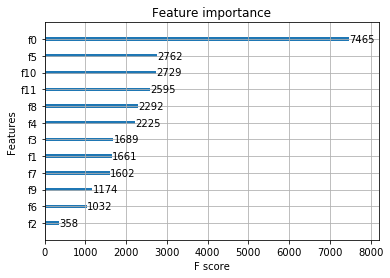

In [254]:
model = classifier_xgb
from xgboost import plot_importance
plot_importance(model)
importance = pd.concat([pd.DataFrame(X_train.columns),pd.DataFrame(model.feature_importances_)], axis=1)
importance.columns = ['feature', 'importance']
print(importance)

Surprisingly, device type and OS have relatively lower importance than IP address and apps. Let's try to retrain the model with less feature over 4 interations by removing one feature each time to see it affects the result.

In [196]:
feature_order = [0,11,5,4,6,3,9,7,1,10,2,8]

In [198]:
for n in range(11,7,-1):
    feature_selected = feature_order[:n+1]
    x_train_res_select = x_train_res[:,feature_selected]
    X_test_select = X_test.iloc[:,feature_selected]
    x_val_select = x_val.iloc[:,feature_selected]
    
    classifier_xgb_retrain = XGBClassifier(learning_rate=0.3, max_depth=10, n_estimators=100, colsample_bytree=1, seed=0, subsample=1)
    classifier_xgb_retrain.fit(x_train_res_select, y_train_res)
    
    print('Model trained using %s feature(s)' %(n+1))
    y_val_pred_retrain = classifier_xgb_retrain.predict(x_val_select.values)
    print('XGBoost accuracy score of the validation set:')
    print(accuracy_score(y_val, y_val_pred_retrain))
    
    y_pred_retrain = classifier_xgb_retrain.predict(X_test_select.values)
    print('XGBoost accuracy score of the test set:')
    print(accuracy_score(y_test, y_pred_retrain))
    
    report = classification_report(y_test, y_pred_retrain)
    print(report)
    
    print('\n')

Model trained using 12 feature(s)
XGBoost accuracy score of the validation set:
0.988629136227
XGBoost accuracy score of the test set:
0.989108686235
             precision    recall  f1-score   support

          0       0.99      0.99      0.99    199511
          1       0.98      0.99      0.98     91363

avg / total       0.99      0.99      0.99    290874



Model trained using 11 feature(s)
XGBoost accuracy score of the validation set:
0.988766652342
XGBoost accuracy score of the test set:
0.989242764909
             precision    recall  f1-score   support

          0       0.99      0.99      0.99    199511
          1       0.98      0.99      0.98     91363

avg / total       0.99      0.99      0.99    290874



Model trained using 10 feature(s)
XGBoost accuracy score of the validation set:
0.988861194671
XGBoost accuracy score of the test set:
0.989067431259
             precision    recall  f1-score   support

          0       0.99      0.99      0.99    199511
         

As seen from the results above, the accuracy is at its highest when 11 features (eliminating device_count feature) were used to train the XGBoost model. It's still interesting to see that by using adding ip_app_hour_count as feature, the recall rate of attributed clicks was able to increase from 88% to 99%. 

#### Tuning XGBoost Hyperparameters

In [87]:
from sklearn.grid_search import GridSearchCV

cv_params = {'max_depth': [5,10], 'min_child_weight': [1,3]}
ind_params = {'learning_rate': 0.3, 'n_estimators': 100, 'seed':0, 'subsample': 1, 'colsample_bytree': 1, 'objective': 'binary:logistic'}

optimized_xgb = GridSearchCV(XGBClassifier(**ind_params), cv_params, scoring = 'accuracy', cv = 5, n_jobs = -1) 



In [88]:
optimized_xgb.fit(x_train_res, y_train_res)

GridSearchCV(cv=5, error_score='raise',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=0, silent=True,
       subsample=1),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'max_depth': [5, 10, 11], 'min_child_weight': [1, 3, 5], 'learning_rate': [0.3, 0.7]},
       pre_dispatch='2*n_jobs', refit=True, scoring='accuracy', verbose=0)

In [89]:
optimized_xgb.grid_scores_

[mean: 0.95441, std: 0.03459, params: {'learning_rate': 0.3, 'max_depth': 5, 'min_child_weight': 1},
 mean: 0.95432, std: 0.03466, params: {'learning_rate': 0.3, 'max_depth': 5, 'min_child_weight': 3},
 mean: 0.95437, std: 0.03471, params: {'learning_rate': 0.3, 'max_depth': 5, 'min_child_weight': 5},
 mean: 0.95681, std: 0.03285, params: {'learning_rate': 0.3, 'max_depth': 10, 'min_child_weight': 1},
 mean: 0.95680, std: 0.03289, params: {'learning_rate': 0.3, 'max_depth': 10, 'min_child_weight': 3},
 mean: 0.95679, std: 0.03294, params: {'learning_rate': 0.3, 'max_depth': 10, 'min_child_weight': 5},
 mean: 0.95681, std: 0.03277, params: {'learning_rate': 0.3, 'max_depth': 11, 'min_child_weight': 1},
 mean: 0.95671, std: 0.03281, params: {'learning_rate': 0.3, 'max_depth': 11, 'min_child_weight': 3},
 mean: 0.95676, std: 0.03278, params: {'learning_rate': 0.3, 'max_depth': 11, 'min_child_weight': 5},
 mean: 0.95623, std: 0.03369, params: {'learning_rate': 0.7, 'max_depth': 5, 'min_chi

The results of my grid search with 5-fold cross-validation show that max_depth = 10 or 11, min_child_weight=1, and learning rate =0.3 perform the best. The initial model was trained using these exact parameters and is thus the most optimal one. 

#### Evaluate AUC

In [199]:
from sklearn.metrics import roc_curve, auc
predictions = classifier_xgb.predict_proba(X_test.values)[:,1]
actual = y_test.values
false_positive_rate, true_positive_rate, thresholds = roc_curve(actual, predictions)
roc_auc = auc(false_positive_rate, true_positive_rate)

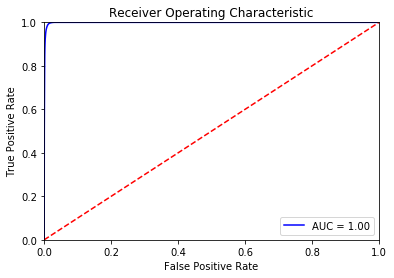

In [200]:
plt.title('Receiver Operating Characteristic')
plt.plot(false_positive_rate, true_positive_rate, 'b',
label='AUC = %0.2f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([0,1])
plt.ylim([0,1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

Finally, the results of my classification model are shown in the above ROC curve. The plot shows that my model has a ROC curves in the area with the top left corner (0.0, 1.0) indicate very good performance level. 

## Generate Predictions

In [214]:
feature_selected = feature_order[:11]
x_train_res_select = x_train_res[:,feature_selected]
X_test_select = X_test.iloc[:,feature_selected]
x_val_select = x_val.iloc[:,feature_selected]
    
classifier_xgb_retrain = XGBClassifier(learning_rate=0.3, max_depth=10, n_estimators=100, colsample_bytree=1, seed=0, subsample=1)
classifier_xgb_retrain.fit(x_train_res_select, y_train_res)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.3, max_delta_step=0,
       max_depth=10, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=0, silent=True,
       subsample=1)

In [456]:
test_data = pd.read_csv('test.csv', dtype=dtypes)
test_data['click_time'] = pd.to_datetime(test_data['click_time'])
test_data['hour']=test_data.click_time.dt.hour
test_data['period']=pd.cut(test_data.click_time.dt.hour,[-1,6,12,18,24],labels=['Night','Morning','Afternoon','Evening'])
test_data.drop('click_time', axis=1,inplace=True)
test_data.drop('period', axis=1,inplace=True)


features = ['app','os','channel','device']

for n in range(0,len(features)):
    total_count = train.groupby(features[n])['is_attributed'].count().reset_index()
    total_count.columns = [features[n], features[n]+'_ttl_count']
    attr_count = train[train['is_attributed'] == 1].groupby(features[n])['is_attributed'].count().reset_index()
    attr_count.columns = [features[n], features[n]+'_attr_count']
    count = pd.merge(total_count, attr_count, how='left', on=[features[n]])
    count.columns = [features[n],'ttl','attr']
    count[features[n]+'_attr_rate'] = count['attr']/count['ttl']
    count.drop(['ttl','attr'], axis=1,inplace=True)
    
    test_data = pd.merge(test_data, count, how='left', on=[features[n]])
    test_data[features[n]+'_attr_rate'].fillna(0, inplace=True)

pair_features = ['os','channel','device']

for n in range(0,3):
    total_count = train.groupby(['app', pair_features[n]])['is_attributed'].count().reset_index()
    total_count.columns = ['app', pair_features[n], 'app_'+pair_features[n]+'_ttl_count']
    attr_count = train[train['is_attributed'] == 1].groupby(['app', pair_features[n]])['is_attributed'].count().reset_index()
    attr_count.columns = ['app', pair_features[n], 'app_'+pair_features[n]+'_attr_count']
    count = pd.merge(total_count, attr_count, how='left', on=['app', pair_features[n]])
    count.columns = ['app', pair_features[n],'ttl','attr']
    count['app_'+pair_features[n]+'_attr_rate'] = count['attr']/count['ttl']
    count.drop(['ttl','attr'], axis=1,inplace=True)
    
    test_data = pd.merge(test_data, count, how='left', on=['app', pair_features[n]])
    test_data['app_'+pair_features[n]+'_attr_rate'].fillna(0, inplace=True)



In [457]:
test_data.head(5)

,click_id,ip,app,device,os,channel,hour,app_attr_rate,os_attr_rate,channel_attr_rate,device_attr_rate,app_os_attr_rate,app_channel_attr_rate,app_device_attr_rate
0,0,5744,9,1,3,107,4,0.010473,0.007754,0.004644,0.01602,0.004135,0.010618,0.011232
1,1,119901,9,1,3,466,4,0.010473,0.007754,0.010195,0.01602,0.004135,0.011657,0.011232
2,2,72287,21,1,19,128,4,0.001230,0.016425,0.001880,0.01602,0.001006,0.000881,0.001284
3,3,78477,15,1,13,111,4,0.001977,0.014146,0.002188,0.01602,0.001820,0.002188,0.002058
4,4,123080,12,1,13,328,4,0.001008,0.014146,0.000958,0.01602,0.000967,0.000958,0.001066


In [458]:
X_submission_id = test_data.click_id
X_submission = test_data.drop(['click_id','ip'], axis=1) 

In [459]:
y_submission = classifier_xgb.predict(X_submission)

In [460]:
submission = pd.concat([X_submission_id, pd.DataFrame(y_submission, columns = ['is_attributed'])], axis=1)

In [461]:
submission.head(5)

,click_id,is_attributed
0,0,0
1,1,0
2,2,0
3,3,0
4,4,0


In [462]:
len(submission)

18790469

In [463]:
submission.to_csv('KenLam_submission6.csv', index = False)